# Dependances

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from numba import njit
from timeit import default_timer as timer
from datetime import datetime
import pickle
import pandas as pd
import matplotlib.animation as animation
from scipy.stats import mannwhitneyu
from pulp import *
from itertools import combinations

def time_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_seconds = hours * 60 + minutes
    return total_seconds

def min_to_time(minutes):
    minutes = minutes%1440
    hours = minutes // 60
    minutes = minutes % 60
    time_str = '{:02d}:{:02d}'.format(hours, minutes)
    return time_str

def simulate_instance(n = 20,
                      vehicles_availability_time = "6:00",
                      chargers_availability_time = "6:00",
                      min_required_energy = 30,
                      step = 10,
                      max_required_energy = 100,
                      m = 6,
                      charging_powers = [10,20,30,40],
                      delta = None,
                      alpha = None,
                      tho = 60):
    
    vehicles_availability_time = time_to_min(vehicles_availability_time)
    chargers_availability_time = time_to_min(chargers_availability_time)
    
    scheduling_limit = time_to_min("23:59")
    
    requests = np.empty((n,2), dtype = object)
    for i in range(n):
        arrival = np.random.choice(range(vehicles_availability_time,scheduling_limit+1,tho))
        required_energy = np.random.choice(range(min_required_energy,max_required_energy+1,step))
        requests[i] = [min_to_time(arrival),required_energy]

    chargers = np.empty((m,2), dtype = object)
    for i in range(m):
        charger_availability = min_to_time(np.random.choice(range(chargers_availability_time,scheduling_limit+1,tho)))
        charger_power = np.random.choice(charging_powers)
        chargers[i] = [charger_availability, charger_power]

    if delta is None:
        delta = np.ones((n,m), dtype = np.int8)
        
    if alpha is None:
        alpha = (1/n)*np.ones(n)

    scheduling_start_time = min_to_time(min(vehicles_availability_time,chargers_availability_time))
    
    
    Instance={
        "requests":requests,
        "chargers":chargers,
        "delta":delta,
        "alpha":alpha,
        "tho":tho
    }
    return Instance
    
def calculate_carecs(Instance):
    requests = Instance["requests"]
    chargers = Instance["chargers"]
    delta = Instance["delta"]
    alpha = Instance["alpha"]
    tho = Instance["tho"]

    n,m = len(requests),len(chargers)
    # Calculate p
    p = np.zeros((n,m),dtype=np.int16)
    for i in range(n):
        for j in range(m):
            p[i,j]=ceil(requests[i,1]/((tho/60)*chargers[j,1]))

    # Calculate requests_temp, chargers_temp
    M = np.min([time_to_min(x[0]) for x in requests]+[time_to_min(x[0]) for x in chargers])
    requests_temp = np.array([[int((time_to_min(request[0]) - M)/tho)+1,request[1]] for request in requests])
    chargers_temp = np.array([[int((time_to_min(charger[0]) - M)/tho)+1,charger[1]] for charger in chargers])

    scheduling_start_time = M
    
    return n, m, requests, chargers, delta, alpha, tho, scheduling_start_time, requests_temp, chargers_temp, p

def plot_schedule(Instance, schedule, figsize=(15, 7)):
    n, m, requests, chargers, delta, alpha, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
    T = max(schedule[:, 2])
    start_index = scheduling_start_time
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot black lines for chargers
    for j in range(m):
        ax.plot(np.arange(chargers_temp[j, 0], T + 2), (j + 1) * np.ones(T + 1 - chargers_temp[j, 0] + 1), lw=2, c="blue")
    
    text = ""
    for i in range(n):
        text += f" $V_{{{i+1}}}$: ({requests[i, 0]}, {requests[i, 1]}kWh), "
        if (i + 1) % 10 == 0:
            text += "\n"
        mid_point = (schedule[i, 1] + schedule[i, 2]) / 2
        ax.text(mid_point, schedule[i, 0] + 0.3, f"$V_{{{i+1}}}$", fontsize=8, ha='center')
        ax.plot(np.arange(schedule[i, 1], schedule[i, 2] + 1), schedule[i, 0] * np.ones(schedule[i, 2] - schedule[i, 1] + 1), c="red", lw=5, marker=".", ms=22)

    xticks = [min_to_time(start_index + t * tho) + "\n" + min_to_time(start_index + (t + 1) * tho) for t in range(T + 1)]
    ax.set_xticks(np.arange(1, T + 2))
    ax.set_xticklabels(xticks, rotation=40, fontsize=6)
    ax.set_yticks(range(1, m + 1))
    ax.set_yticklabels([f"Charger {j} \n ({chargers_temp[j - 1][1]} kW)" for j in range(1, m + 1)], fontsize=9)
    ax.set_xlim(0.5, T + 1.5)
    ax.set_ylim(0, m + 1)
    ax.grid()
    
    # Add the text at the bottom of the figure
    fig.text(0.5, -0.1, text, ha='center', va='center', fontsize=7)  # Adjust position as needed
    
    # Save the figure
    plt.close(fig)
    
    return fig

@njit
def random_choice(x, size=1, replace=True, p=None):
    n = len(x)
    selected = np.zeros(size, dtype=np.int64)
    possible_indices = np.arange(n)
    
    if p is None:
        p = np.ones(n, dtype=np.float64) / n
        
    for i in range(size):
        cdf = np.cumsum(p)
        r = np.random.rand()
        for index, threshold in enumerate(cdf):
            if r <= threshold:
                selected[i] = x[possible_indices[index]]
                break
                
        if replace == False and size > 1:
            possible_indices = np.delete(possible_indices, index)
            p = np.array([a for k,a in enumerate(p) if k != index])
            p = p / p.sum()
            
    return selected

@njit
def find_availability(schedule,chargers_temp,j):
    sub_schedule = schedule[schedule[:,0]==j+1]
    sub_schedule = sub_schedule[np.argsort(sub_schedule[:,1])]
    N = len(sub_schedule)
    availability = np.zeros((N+1,2), dtype = np.int64)
    if N>0:
        availability[0] = np.array([chargers_temp[j,0],sub_schedule[0,1]-1])
        for k in range(1,N):
            availability[k] = np.array([sub_schedule[k-1,2]+1,sub_schedule[k,1]-1])
        availability[N] = np.array([sub_schedule[N-1,2]+1,123456789])
    else:
        availability[0] = np.array([chargers_temp[j,0],123456789])
    return availability

@njit
def find_candidate_charging_periods(i, j, availability, requests_temp, chargers_temp, p):
    candidate_charging_periods =[]
    for k in range(len(availability)):
        if availability[k,1] == 123456789:
            candidate_charging_periods.append(k)
        elif availability[k,1]-max(availability[k,0],requests_temp[i,0])+1>=p[i,j]:
            candidate_charging_periods.append(k)
    return np.array(candidate_charging_periods)

@njit
def generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = 5):
    n = len(requests_temp)
    m = len(chargers_temp)
    schedule = np.zeros((n,3), dtype = np.int32)
    vehicles_indexes = np.arange(n)
    np.random.shuffle(vehicles_indexes)
    for i in vehicles_indexes:
        candidate_chargers = np.arange(m)[delta[i,:] == 1]
        j = np.random.choice(candidate_chargers)
        schedule = place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma)
    return schedule

@njit
def place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma):
    n,m = p.shape
    schedule = schedule.copy()

    availability = find_availability(schedule,chargers_temp,j)
    candidate_charging_periods = find_candidate_charging_periods(i, j, availability, requests_temp, chargers_temp, p)
    
    N = len(candidate_charging_periods)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)
    k = random_choice(candidate_charging_periods, p = probabilities)[0]
    
    A = max(availability[k,0],requests_temp[i,0])
    if availability[k,1] == 123456789:
        ts = A+int(np.abs(sigma*np.random.randn()))
    else:
        ts = np.random.choice(np.arange(A,availability[k,1]-p[i,j]+2))
        
    schedule[i] = [j+1,ts,ts+p[i,j]-1]
    
    return schedule


@njit
def exchange_schedules(schedule1,schedule2):
    schedule2 = schedule2.copy()
    n = len(schedule1)
    can_be_placed = []
    for i in range(n):
        placable = True
        for j in range(n):
            if schedule1[i, 0] == schedule2[j, 0]:
                if schedule1[i, 1] > schedule2[j, 2] or schedule2[j, 1] > schedule1[i, 2]:
                    pass
                else:
                    placable = False
                    break
        if placable:
            can_be_placed.append(i)
    K = ceil(len(can_be_placed)/3)
    to_be_replaced = random_choice(can_be_placed, size = K, replace = False)
    for i in to_be_replaced:
        schedule2[i] = schedule1[i]
    return schedule2


@njit
def change_vehicle_charger(schedule,requests_temp,chargers_temp,delta,p,sigma):
    n,m = p.shape
    schedule = schedule.copy()
    
    candidate_vehicles = np.array([i for i in range(n) if np.sum(delta[i,:])>1], dtype = np.int32)
    i = np.random.choice(candidate_vehicles)
    
    candidate_chargers = np.array([j for j in range(m) if delta[i,j] == 1 and j!=schedule[i,0]-1], dtype = np.int32)
    j = np.random.choice(candidate_chargers)
    
    return place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma)



@njit
def f(schedule, chargers_temp, alpha):
    n = len(schedule)
    T1 = np.min(schedule[:,1])
    T2 = np.max(schedule[:,2])
    Wg = np.zeros(T2-T1+1, dtype = np.float64)
    for i in range(n):
        for t in range(schedule[i,1],schedule[i,2]+1): 
            Wg[t-T1] += chargers_temp[schedule[i,0]-1,1]
    return np.array([np.max(Wg) ,np.sum(schedule[:,2]*alpha)], dtype = np.float32)


@njit
def fast_non_dominated_sort(obj1, obj2):
    N = len(obj1)
    S = np.zeros((N, N), dtype = np.int64)
    ranks = np.zeros(N, dtype = np.int64)
    fronts = []
    count = N
    front = []
    for p in range(N):
        for q in range(N):
            if (obj1[p] < obj1[q] and obj2[p] <= obj2[q]) or (obj1[p] <= obj1[q] and obj2[p] < obj2[q]):
                S[p][q] = 1
    for p in range(N):
        if np.sum(S[:, p]) == 0:
            front.append(p)
            ranks[p] = 0
            count -= 1
    fronts.append(np.array(front))
    n = np.sum(S, axis=0)
    i = 0
    while count > 0:
        front = []
        for p in fronts[i]:
            for q in range(N):
                if S[p][q] == 1:
                    n[q] -= 1
                    if n[q] == 0:
                        front.append(q)
                        ranks[q] = i + 1
                        count -= 1
        fronts.append(np.array(front))
        i += 1
    return fronts, ranks



@njit
def calculate_crowding_distance(fronts, obj1, obj2):
    objectives = [obj1, obj2]
    d = np.zeros(len(obj1), dtype = np.float64)
    for front in fronts:
        lf = len(front)
        distances = np.zeros(lf, dtype = np.float64)
        distances[0] = 999999999999
        distances[-1] = 999999999999
        for obj in objectives:
            sorted_front = np.empty(lf, dtype=np.int32)
            indices = np.argsort(np.array([obj[i] for i in front]))
            for idx in range(lf):
                sorted_front[idx] = front[indices[idx]]
            for j in range(1, lf - 1):
                diff = obj[sorted_front[-1]] - obj[sorted_front[0]]
                if diff == 0:
                    distances[j] = 999999999999
                else:
                    distances[j] += (obj[sorted_front[j + 1]] - obj[sorted_front[j - 1]]) / diff
        for idx in range(lf):
            d[sorted_front[idx]] = distances[idx]
    return d


@njit
def sort_population(population, chargers_temp, alpha, population_size):
    N = len(population)
    obj1 = np.zeros(N, dtype = np.float64)
    obj2 = np.zeros(N, dtype = np.float64)
    sorted_fronts = np.zeros(N, dtype = np.int64)
    
    for i in range(N):
        obj1[i],obj2[i] = f(population[i], chargers_temp, alpha)
    fronts, ranks = fast_non_dominated_sort(obj1, obj2)
    distances = calculate_crowding_distance(fronts, obj1, obj2)
    
    i = 0
    for front in fronts:
        temp_front = front[np.argsort(-distances[front])]
        for k in temp_front:
            sorted_fronts[i] = k
            i+=1

    I = sorted_fronts[:population_size]
    return population[I], obj1[I], obj2[I], ranks[I], distances[I]


@njit
def Initialize_population(population_size, delta, requests_temp, chargers_temp, p):
    n = len(requests_temp)
    population = np.zeros((population_size,n,3), dtype = np.int64)
    for k in range(population_size):
        population[k] = generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = k+1)
    return population

@njit
def FN(schedule, requests_temp, chargers_temp, alpha, delta, p, sigma, pc):
    n,m = p.shape
    schedule = schedule.copy()
    candidate_vehicles = np.array([i for i in range(n) if np.sum(delta[i,:])>1], dtype = np.int32)
    for _ in range(ceil(pc*n)):
        i = np.random.choice(candidate_vehicles)
        candidate_chargers = np.array([j for j in range(m) if delta[i,j]==1])
        j = np.random.choice(candidate_chargers)
        schedule = place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma).copy()
    return schedule


@njit
def selection(population, ranks, distances):
    population_size = len(population)
    N = int(population_size/4)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)
    i1,i2 = random_choice(np.arange(N), size = 2, replace = False, p = probabilities)
    if ranks[i1]<ranks[i2]:
        return population[i1]
    elif ranks[i2]<ranks[i1]:
        return population[i2]
    else:
        if distances[i1] > distances[i2]:
            return population[i1]
        elif distances[i2] > distances[i1]:
            return population[i2]
        else:
            return population[i1]
            
@njit
def crossover(schedule1,schedule2):
    return exchange_schedules(schedule2,schedule1), exchange_schedules(schedule1,schedule2)

    
@njit    
def mutation(schedule,requests_temp,chargers_temp,delta,p,sigma,pm2):
    n = len(requests_temp)
    for i in range(ceil(pm2*n)):
        schedule = change_vehicle_charger(schedule,requests_temp,chargers_temp,delta,p,sigma)
    return schedule



@njit
def NSGA2_main(requests_temp, chargers_temp, p, delta, alpha, population_size, generations, pm1, pm2, sigma):
    n, m = p.shape
    offspring = np.empty((population_size, n, 3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)

    
    population = Initialize_population(population_size, delta, requests_temp, chargers_temp, p)
    population, obj1, obj2, ranks, distances = sort_population(population, chargers_temp, alpha, population_size)
    
    for gen in range(generations):
        
        k = 0
        while k < population_size:
            parent1 = selection(population, ranks, distances)
            parent2 = selection(population, ranks, distances)
            child1, child2 = crossover(parent1, parent2)
            if np.random.rand() < pm1:
                child1 = mutation(child1,requests_temp,chargers_temp,delta,p,sigma,pm2)
            if np.random.rand() < pm1:
                child2 = mutation(child2,requests_temp,chargers_temp,delta,p,sigma,pm2)
            offspring[k] = child1
            k += 1
            if k < population_size:
                offspring[k] = child2
                k += 1
                
        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = offspring[k-population_size]
        population, obj1, obj2, ranks, distances = sort_population(combined_population, chargers_temp, alpha, population_size)

    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [obj1[k],obj2[k]]
    return pareto_front, pov

def NSGA2(Instance, population_size=100, generations=200, pm1 = 0.2, pm2 = 0.05, sigma = 10):
    n, m, requests, chargers, delta, alpha, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
    pareto_front, objectives_values_pareto_front = NSGA2_main(requests_temp, 
                                                            chargers_temp, 
                                                            p, 
                                                            delta, 
                                                            alpha, 
                                                            population_size, 
                                                            generations, 
                                                            pm1,
                                                            pm2, 
                                                            sigma)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front,
    }
    return result




@njit
def MOCS_main(requests_temp, chargers_temp, p, delta, alpha, population_size, generations, perc_abandoned, sigma, pc):
    n = len(requests_temp)
    new_population = np.zeros((population_size,n,3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)
    num_abandoned = int(perc_abandoned*population_size)

    N = int(population_size/3)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)

    population = Initialize_population(population_size, delta, requests_temp, chargers_temp, p)
    population, obj1, obj2, ranks, distances = sort_population(population, chargers_temp, alpha, population_size)

    for gen in range(generations):
        
        for i in range(population_size):
            k = random_choice(np.arange(N),p = probabilities)[0]
            new_population[i] = FN(population[k], requests_temp, chargers_temp, alpha, delta, p, sigma, pc)

        for j in range(1,num_abandoned+1):
            population[-j] = FN(population[-j], requests_temp, chargers_temp, alpha, delta, p, sigma, pc)

        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = new_population[k-population_size]
        population, obj1, obj2, ranks, distances = sort_population(combined_population, chargers_temp, alpha, population_size)


    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [obj1[k],obj2[k]]
    
    return pareto_front, pov

def MOCS(Instance, population_size = 100, generations = 200, perc_abandoned = 0.2, sigma = 5, pc = 0.1):
    n, m, requests, chargers, delta, alpha, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
    pareto_front, objectives_values_pareto_front = MOCS_main(requests_temp, 
                                                             chargers_temp, 
                                                             p, 
                                                             delta, 
                                                             alpha, 
                                                             population_size, 
                                                             generations, 
                                                             perc_abandoned, 
                                                             sigma,
                                                             pc)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front
    }
    return result

C:\Users\akhiar\AppData\Local\Temp\ipykernel_15344\1489676200.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Simulate a random instance and generate a random schedule

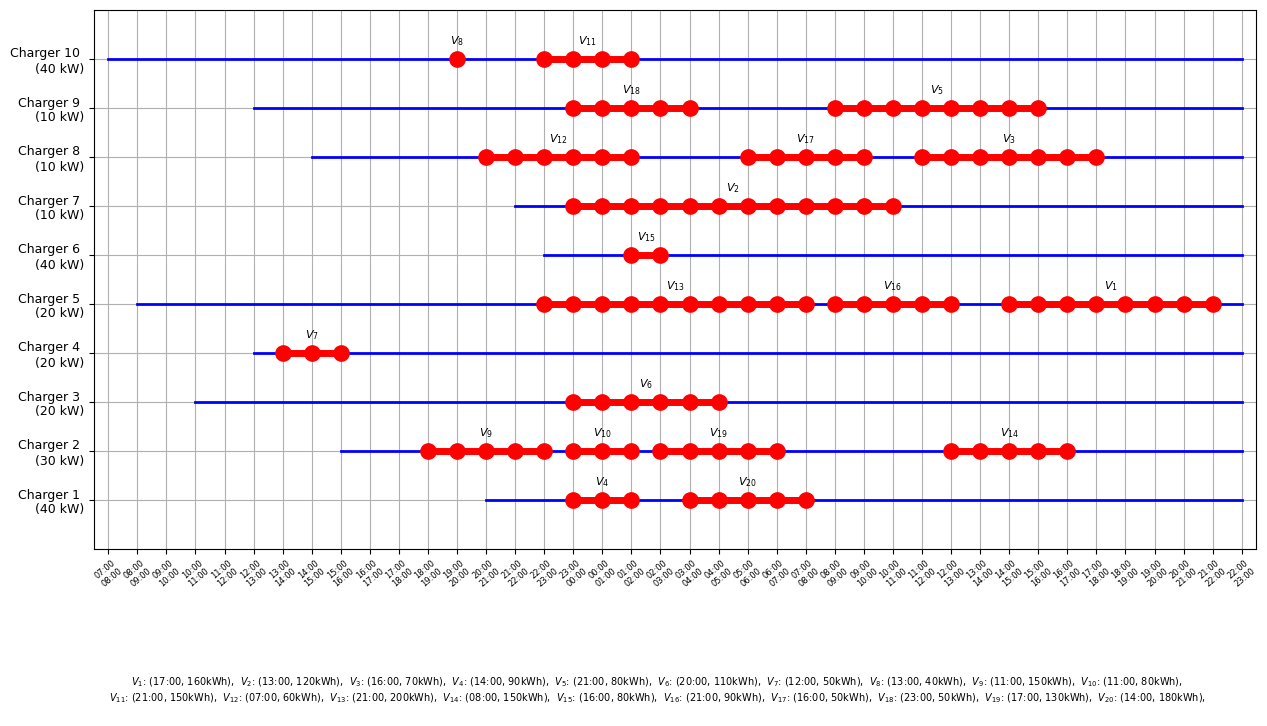

In [44]:
Instance = simulate_instance(n = 20,
vehicles_availability_time = "6:00",
chargers_availability_time = "6:00",
min_required_energy = 30,
step = 10,
max_required_energy = 200,
m = 10,
charging_powers = [10,20,30,40],
delta = None,
alpha = None,
tho = 60)


n, m, requests, chargers, delta, alpha, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
schedule = generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = 5)
plot_schedule(Instance, schedule, figsize=(15, 7))

# NSGA-II

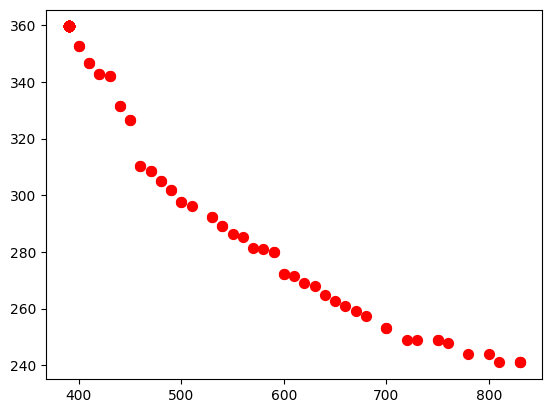

In [45]:
Instance = simulate_instance(n = 200,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 50,
charging_powers = [10,20,30,40],
delta = None,
alpha = None,
tho = 10)

result = NSGA2(Instance, population_size = 200, generations = 300, pm1 = 0.2, pm2 = 0.05, sigma = 1)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=50, c = "red")
plt.show()

# MOCS

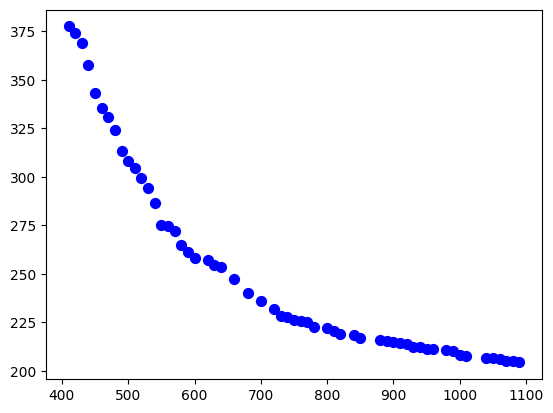

In [41]:
Instance = simulate_instance(n = 200,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 50,
charging_powers = [10,20,30,40],
delta = None,
alpha = None,
tho = 10)

result = MOCS(Instance, population_size = 200, generations = 300, perc_abandoned = 0.25, sigma = 1, pc = 0.05)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=50, c = "blue")
plt.show()

# Single run comparaison between NSGA-II and MOCS

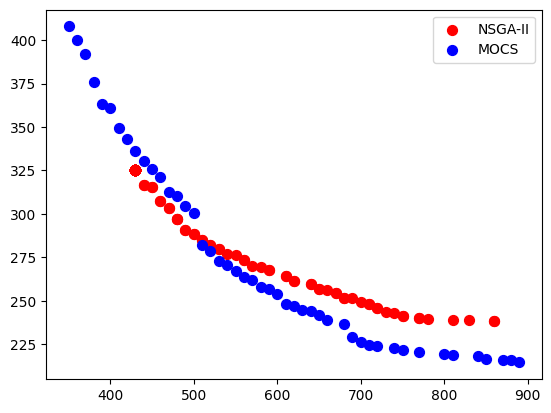

In [43]:
Instance = simulate_instance(n = 200,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 50,
charging_powers = [10,20,30,40],
delta = None,
alpha = None,
tho = 10)

plt.figure()

result = NSGA2(Instance, population_size = 200, generations = 300, pm1 = 0.2, pm2 = 0.05, sigma = 1)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=50, c="red")

result = MOCS(Instance, population_size = 200, generations = 300, perc_abandoned = 0.25, sigma = 1, pc = 0.05)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=50, c="blue")

plt.legend(["NSGA-II", "MOCS"])
plt.show()